<a href="https://colab.research.google.com/github/whtan88/Python-Projects/blob/master/Google_Tensorflow_Certificate_Force_Prep_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Key Concepts:


*   Loading data from a directory
*   Using pretrained model (transfer learning) and freezing layers
*   Employ dropouts
*   Multiple Classification


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#important to use for bypassing cert error issues
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
#Download Rock-Paper_Scissors dataset
# Download the train set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip

# Download the test set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip

#Download the Inception weights we will be using for pretrained model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-04-09 03:58:07--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.207, 142.251.161.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip.1’

rps.zip.1           100%[===================>] 191.38M   220MB/s    in 0.9s    

2024-04-09 03:58:08 (220 MB/s) - ‘rps.zip.1’ saved [200682221/200682221]

--2024-04-09 03:58:08--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.207, 142.251.161.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rp

total training rock images: 840
total training paper images: 840
total training scissors images: 840


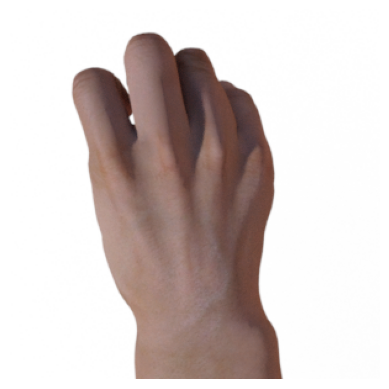

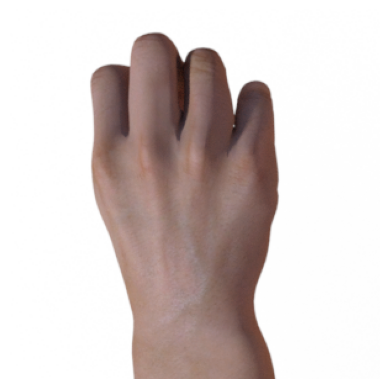

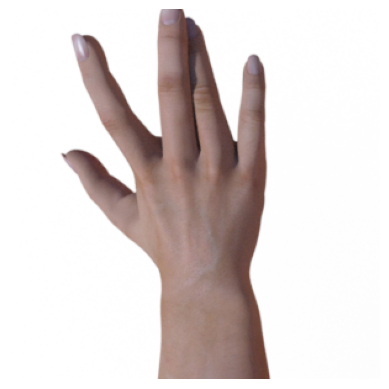

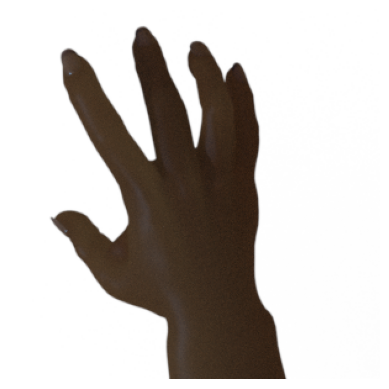

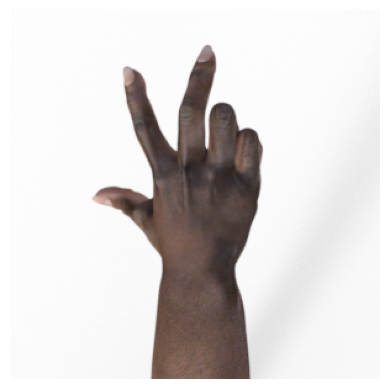

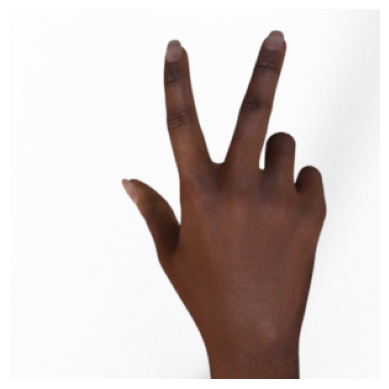

In [ ]:
# Extract the archive
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

base_dir = 'tmp/rps-train/rps'

rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

#Inspecting the data
pic_index = 2
next_rock = [os.path.join(rock_dir, fname)
                for fname in rock_files[:pic_index]]
next_paper = [os.path.join(paper_dir, fname)
                for fname in paper_files[:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname)
                for fname in scissors_files[:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [ ]:
#Building the ImageDataGenerator
TRAINING_DIR = "tmp/rps-train/rps"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test/rps-test-set"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [ ]:
#Building the pretrained inception model
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
# Choosing the last layer of the base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate
x = layers.Dropout(0.25)(x)
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Append the dense network to the base model
model = tf.keras.Model(pre_trained_model.input, x)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data = validation_generator, verbose = 1)

Epoch 1/10
20/20 [==============================] - 35s 1s/step - loss: 6.7290 - accuracy: 0.7056 - val_loss: 2.2633 - val_accuracy: 0.6022
Epoch 2/10
20/20 [==============================] - 23s 1s/step - loss: 0.4468 - accuracy: 0.8988 - val_loss: 0.5445 - val_accuracy: 0.7930
Epoch 3/10
20/20 [==============================] - 23s 1s/step - loss: 0.9063 - accuracy: 0.8528 - val_loss: 0.4954 - val_accuracy: 0.8414
Epoch 4/10
20/20 [==============================] - 23s 1s/step - loss: 0.1031 - accuracy: 0.9635 - val_loss: 0.0555 - val_accuracy: 0.9731
Epoch 5/10
20/20 [==============================] - 23s 1s/step - loss: 0.4253 - accuracy: 0.9302 - val_loss: 0.3107 - val_accuracy: 0.8898
Epoch 6/10
20/20 [==============================] - 23s 1s/step - loss: 0.0694 - accuracy: 0.9750 - val_loss: 0.0547 - val_accuracy: 0.9892
Epoch 7/10
20/20 [==============================] - 23s 1s/step - loss: 0.1721 - accuracy: 0.9504 - val_loss: 0.0609 - val_accuracy: 0.9758
Epoch 8/10
20/20 [==

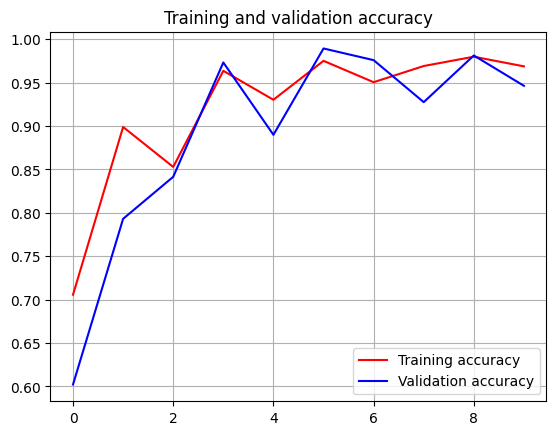

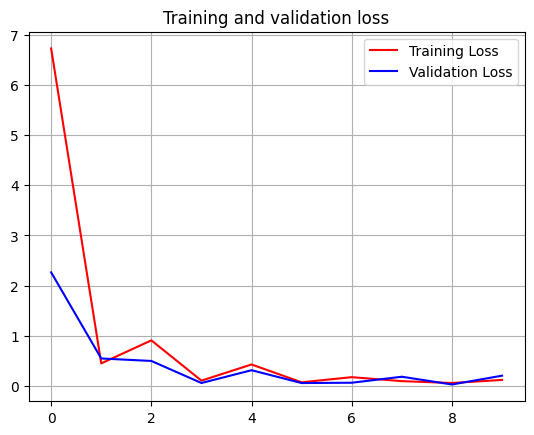

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.grid(True)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.grid(True)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()